In [1]:
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
import math

First we load in our image:

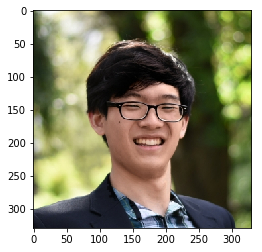

In [2]:
%matplotlib inline
im = Image.open('aj_face.jpeg')
image_tensor = np.asarray(im)
imshow(image_tensor)

As we can see below, the image loads as a numpy ndarray with 329 rows, 330 columns, and 3 depths. That's 330 pixels in _width_, 329 in _height_, and 3 rgb values.

In [3]:
type(image_tensor), image_tensor.shape, image_tensor.dtype

(numpy.ndarray, (329, 330, 3), dtype('uint8'))

I'm going to flatten our numpy array, so that it's a long list of rgb values (instead of a 2d matrix of them).

In [4]:
flattened_pixels = image_tensor.reshape((329 * 330, 3)) # directly from np.array(im.getdata()) also works
flattened_pixels, flattened_pixels.shape, flattened_pixels.dtype

(array([[ 87,  90,  59],
        [ 93,  98,  66],
        [100, 105,  73],
        ..., 
        [146, 165,  83],
        [144, 166,  83],
        [144, 166,  84]], dtype=uint8), (108570, 3), dtype('uint8'))

Let's double check how the reshaping works. From the original 2d matrix of rgb values, we'll select up to the first 5 'x' pixels along the first row. As we see below, the flattening works left to right, top down.

In [5]:
image_tensor[0,:5,:]

array([[ 87,  90,  59],
       [ 93,  98,  66],
       [100, 105,  73],
       [115, 122,  91],
       [131, 140, 109]], dtype=uint8)

The next syntax can be a bit convoluted. All it's doing is attaching each pixel's coordinate as a vector to its rgb value. This way we can perform the rotation matrix operation on the location matrix later. We're also translating our coordinates so that the origin lies at the center of the image.

In [6]:
coordinate_generator = (np.array([x - 165, y - 165]) for x in range(330) for y in range(329))
coordinates_and_rgb = zip(coordinate_generator, flattened_pixels)

Now we define a function to get a rotation matrix for a specified angle. We create a rotation matrix for 30 degrees counterclockwise.

In [7]:
def rotation_matrix(degree):
    """ Return a rotation matrix that rotates by the given angle in degrees """
    theta = math.radians(degree)
    return np.array([
        [math.cos(theta), math.sin(theta)],
        [-math.sin(theta), math.cos(theta)]
    ])

rotate_30_matrix = rotation_matrix(30)
rotate_30_matrix

array([[ 0.8660254,  0.5      ],
       [-0.5      ,  0.8660254]])

Let's apply the matrix transformation to each of the coordinates.

In [8]:
def rotate(point):
    location, rgb = point
    return (rotate_30_matrix.dot(location), rgb)

rotated_points = np.array(list(map(rotate, coordinates_and_rgb)))
rotated_points

array([[array([-225.39419162,  -60.39419162]),
        array([87, 90, 59], dtype=uint8)],
       [array([-224.89419162,  -59.52816622]),
        array([93, 98, 66], dtype=uint8)],
       [array([-224.39419162,  -58.66214082]),
        array([100, 105,  73], dtype=uint8)],
       ..., 
       [array([ 222.52816622,   57.43009001]),
        array([146, 165,  83], dtype=uint8)],
       [array([ 223.02816622,   58.29611541]),
        array([144, 166,  83], dtype=uint8)],
       [array([ 223.52816622,   59.16214082]),
        array([144, 166,  84], dtype=uint8)]], dtype=object)

Get the min and max x and y values, so we know how big to make our new matrix

In [21]:
min_x = min(rotated_points, key=lambda a: a[0][0])[0][0]
max_x = max(rotated_points, key=lambda a: a[0][0])[0][0]
min_y = min(rotated_points, key=lambda a: a[0][1])[0][1]
max_y = max(rotated_points, key=lambda a: a[0][1])[0][1]

num_cols = math.ceil(max_x - min_x)
num_rows = math.ceil(max_y - min_y)
print(f'Num columns: {num_cols}. Num rows: {num_rows}')

Num columns: 449. Num rows: 449


Our image dimensions grew. That's to be expected, as rotating moves the corners farther up.

In [46]:
tilted_image = np.zeros((num_rows, num_cols,3), np.int8)
tilted_image

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=int8)

In [50]:
for point in rotated_points:
    (col, row), rgb = point # might be something wonky with row/col
    col, row = int(round(col)), int(round(row))
    tilted_image[row][col] = rgb
    tilted_image[row][col]
    #print(f'Row: {row}. Col: {col}')
    
tilted_image

array([[[-102,  -96,  122],
        [ -97,  -91, -127],
        [ -99,  -87, -127],
        ..., 
        [   0,    0,    0],
        [-109, -102,  120],
        [-105,  -98,  125]],

       [[-100,  -95, -125],
        [   0,    0,    0],
        [ -96,  -92, -119],
        ..., 
        [-117, -112,  121],
        [-111, -105,  125],
        [   0,    0,    0]],

       [[-107, -103, -120],
        [-100,  -97, -116],
        [ -97,  -94, -113],
        ..., 
        [-121, -117,  114],
        [-116, -113,  124],
        [-111, -106, -126]],

       ..., 
       [[   0,    0,    0],
        [  85,  105,   52],
        [  81,   99,   47],
        ..., 
        [  99,  116,   71],
        [  83,  101,   51],
        [  86,  106,   57]],

       [[ 105,  123,   75],
        [ 104,  124,   73],
        [  86,  107,   51],
        ..., 
        [ -98,  -83, -122],
        [-123, -108,  107],
        [-116, -101,  114]],

       [[-114,  -99,  116],
        [   0,    0,    0],
        [-1

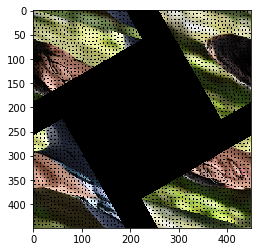

In [54]:
img = Image.fromarray(tilted_image, 'RGB')
img.save('tilted.png')
imshow(img)